<a href="https://colab.research.google.com/github/mahdie-1993/Machine_learning_with_Python_project/blob/main/Recommender_systems_Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget -O moviedataset.zip https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/data/moviedataset.zip
print('unziping ...')
!unzip -o -j moviedataset.zip 

--2022-09-10 22:56:41--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/data/moviedataset.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160301210 (153M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>] 152.88M  19.8MB/s    in 8.8s    

2022-09-10 22:56:51 (17.3 MB/s) - ‘moviedataset.zip’ saved [160301210/160301210]

unziping ...
Archive:  moviedataset.zip
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: README.txt              
  inflating: tags.csv        

In [ ]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## **Preprocessing**

In [ ]:

movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False) #از دیتاست موردنظرمون ستون تایتل رو انتخاب میکنیم،و اون بخش هایی از داده های متنی مون رو که شامل عبارت داخل کوتیشن مارک هست انتخاب میکنیم و براش یک ستون جداگانه به اسم سال قرار میدیم داخل دیتاست
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False) #حالا اون بخشی که بالا جدا کردیم باید پرانتزهاش برداشته بشن.از ایده کد بالا و با رجکس ها دوباره قسمت های موردنظرمون یعنی عدد سالها رو فقط داخل سطرهای ستون سال باقی میگذاریم
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '') #با استفاده از دستورات رجکس مشابه بالا استفاده میکنیم و اینبار پرانتز و سال رو با اسپیس جابجا میکنیم.درواقع حذف میکنیم سال رو از ستون تایتل
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip()) #فضای خالی ک دوطرف رشته های متنی وجود دارد حذف میکنیم
movies_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [ ]:
#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head() #لازم هست علامت را از سطرهای ستون ژانر هم پاک کنیم

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


در این مرحله قصد داریم ستون ژانر را که هرکدام شامل یک لیست هست بطور درستی قابل استفاده کنیم.لازم است ژانرهای موجود در این ستون هرکدام خو یک ستون جداگانه شوند و هر فیلم (هر سطری از دیتاست) که به این ژانر تعلق دارد با 1 نمایش داده شود

In [ ]:
moviesWithGenres_df = movies_df.copy() #کپی از دیتافریم میگیریم
for index, row in movies_df.iterrows(): # عمل تکرار شونده برای هرکدام از سطرهای دیتاست
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1 #لیستی که از ژانرها در هر سطر داریم رو با شماره ردیفش درنظر میگیریم و به ازای هر کدوم از ژانرها که در یک سطر وجود داره 1 قرار میدیم***
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0) #مقادیر از دست رفته را صفر قرار میدیم
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ratings_df.head(9) #ذیتاست بعدی

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496
5,2,112552,5.0,1436165496
6,2,112556,4.0,1436165499
7,3,356,4.0,920587155
8,3,2394,4.0,920586920


In [ ]:
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head() #ستون زمان رو پاک میکنیم 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


## **Content-Based recommendation system**

سیستم پیشنهاد دهنده مبتنی بر محتوا

> 


ابتدا لیستی از فیلم هایی که کاربر تماشا کرده بهمراه نمره ای که به هرکدام از فیلم ها داده احتیاج داریم

In [ ]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput) #لیست را به دیتافریم تبدیل میکنیم
inputMovies 

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


حالا از دیتاستی که از فیلم ها داریم ، ردیفهایی را جدا میکنیم که شامل فیلم هایی هست که کاربر تماشا کرده




در واقع میخواهیم با اینکار 
id 
فیلم هایی که کاربر دیده را به دیتاست اضافه کنیم.




In [ ]:

inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())] #az dataset movies_df onhayii ro mikham k dar title ba inputMovies man moshtarak ast
inputMovies = pd.merge(inputId, inputMovies) #merge dataset ha, hala dg inputMovies man id filmha ra ham darad
inputMovies = inputMovies.drop('genres', 1).drop('year', 1) #hazf column haye ezafe
inputMovies

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5
4,1968,"Breakfast Club, The",5.0


مقادیر ستون ژانر فیلم هایی که کاربر تماشا کرده را جدامیکنیم

In [ ]:
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies #میخواهیم ماتریس ویژگی فیلم هایی که کاربر تماشا کرده را جدا کنیم

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1885,1968,"Breakfast Club, The","[Comedy, Drama]",1985,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ستون های غیرضروری را حذف میکنیم .چون ما بدنال درست کردن یک پروفایل برای کاربر هستیم و کافیست ماتریسی از ژانز فیلم هایی که تماشا کرده داشته باشیم.چون گزینش فیلم هارا هم انجام داده ایم ستون ایندکس را ریست میکنیم

In [ ]:
userMovies = userMovies.reset_index(drop=True)
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


inputMovies['rating']

In [ ]:
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
4    5.0
Name: rating, dtype: float64

ما آرایه ای از نظرات کاربر را داریم،همچنین ماتریسی از ویژگی هریک از فیلم هایی که تماشا کرده هم داریم.با ضرب این دو عبارت در یکدیگر مانند تصویر زیر به پروفایلی از علاقمندی های کاربر دست پیدا میکنیم

درواقع میخواهیم بفهمیم به هر ژانری چه میزان علاقه داره

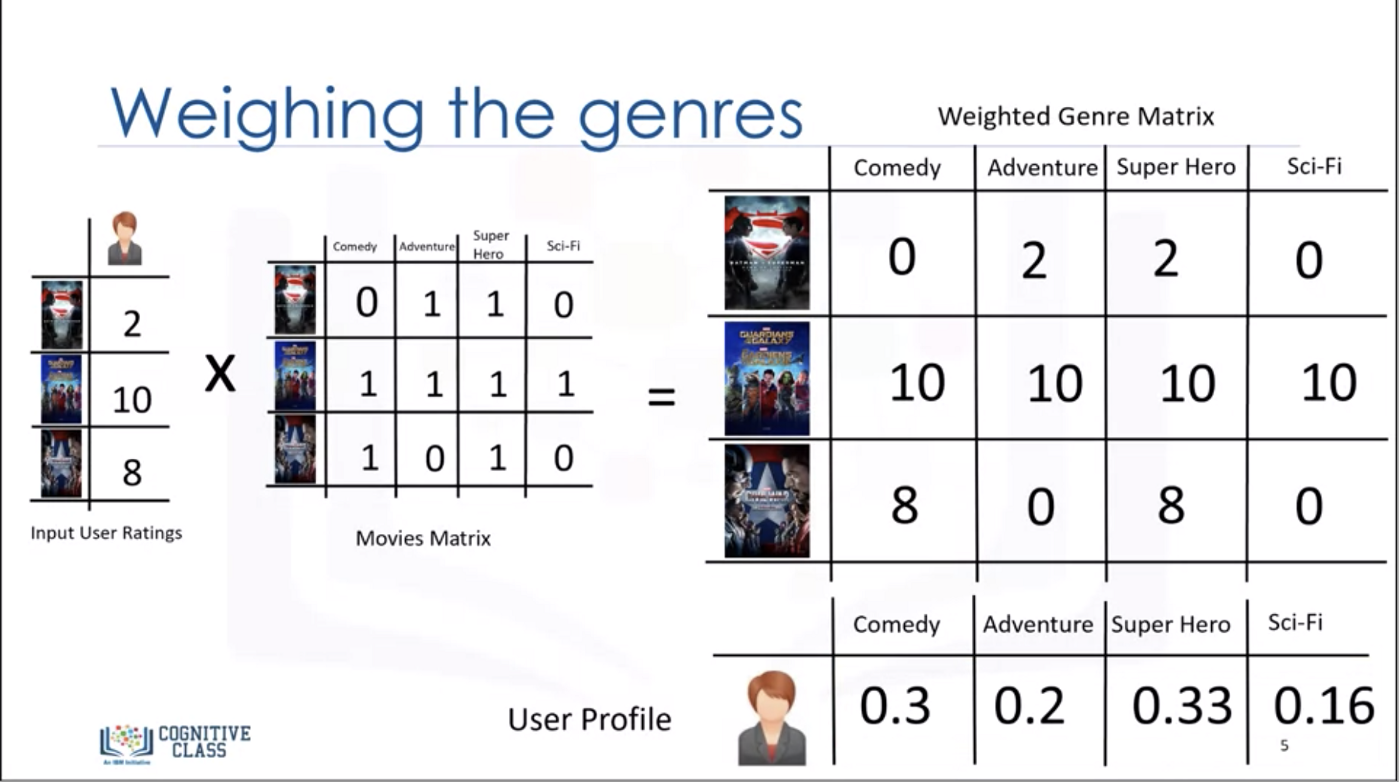

In [ ]:
userProfile = userGenreTable.transpose().dot(inputMovies['rating']) # برای ضرب ماتریسی انجام دادن ترانهاده ماتریس ویژگی فیلم هارا در ماتریس ستونی نظرسنجی اولیه ضرب میکنیم
userProfile

Adventure             10.0
Animation              8.0
Children               5.5
Comedy                13.5
Fantasy                5.5
Romance                0.0
Drama                 10.0
Action                 4.5
Crime                  5.0
Thriller               5.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

حالا که پروفایل کاربر را ایجاد کردیم میخواهیم در دیتاست اصلی فیلم ها به دنبال فیلم هایی باشیم که بیشترین شباهت را با علاقمندی کاربر دارند

In [ ]:
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId']) #برای اینک ستون آیدی را از دست ندهیم و همچنین محاسبات را تغییر ندهد آنرا بعنوان ایندکس در نظر میگیریم
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1) #ستون هایی که لازم نیستند حذف میکنیم
genreTable.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
genreTable.shape

(34208, 20)

حالا بسادگی با ضرب کردن مقادیر پروفایل کاربر  در ماتریس ویژگی فیلم ها امتیاز هر فیلم را محاسبه میکنیم
(میدانیم منظور از امتیاز هرفیلم،امتیازی هست که هر فیلم برای کاربر داره که باتوجه به نظرسنجی اش روی فیلم های قبلی دست آوردیم)

In [ ]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum()) #تقسیم جهت نرمالایز
recommendationTable_df.head()

movieId
1    0.594406
2    0.293706
3    0.188811
4    0.328671
5    0.188811
dtype: float64

In [ ]:
recommendationTable_df = recommendationTable_df.sort_values(ascending=False) #نتایج امتیاز فیلم هارا نزولی مرتب میکنیم
recommendationTable_df.head(20)

movieId
5018      0.748252
26093     0.734266
27344     0.720280
148775    0.685315
6902      0.678322
117646    0.678322
122787    0.671329
64645     0.671329
81132     0.671329
2987      0.664336
91335     0.657343
673       0.657343
51632     0.657343
51939     0.657343
32031     0.657343
26340     0.657343
1907      0.657343
108932    0.657343
108540    0.657343
146305    0.657343
dtype: float64

In [ ]:
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())] #ما به اسم فیلم ها احتیاچ داشتیم پس  ا فراخوانی نتایجمون از روی دیتاست اولیه، اسم فیلم های پیشنهادی رو خواهیم داشت

,movieId,title,genres,year
664,673,Space Jam,"[Adventure, Animation, Children, Comedy, Fanta...",1996
1824,1907,Mulan,"[Adventure, Animation, Children, Comedy, Drama...",1998
2902,2987,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988
4923,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
6793,6902,Interstate 60,"[Adventure, Comedy, Drama, Fantasy, Mystery, S...",2002
8605,26093,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962
8783,26340,"Twelve Tasks of Asterix, The (Les douze travau...","[Action, Adventure, Animation, Children, Comed...",1976
9296,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
9825,32031,Robots,"[Adventure, Animation, Children, Comedy, Fanta...",2005
11716,51632,Atlantis: Milo's Return,"[Action, Adventure, Animation, Children, Comed...",2003
